In [1]:
import numpy as np
import networkx as nx

#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_format = 'retina'

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader # (testset, batch_size=4,shuffle=False, num_workers=4)
from torch.optim.lr_scheduler import ReduceLROnPlateau as RLRP
from torch.nn.parallel import DistributedDataParallel, DataParallel
from torch.nn.init import xavier_normal
from torch.nn.parameter import Parameter
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import sys
from datetime import datetime
from functools import reduce
import os
import os.path
import pandas as pd
import pickle
import importlib
from collections import Counter
from copy import deepcopy
from collections import OrderedDict

import nkmodel as nk
import ppo.core as core
from ppo.ppo import PPOBuffer
from utils.utils import max_mean_clustering_network, real_network
import envs
import json
from itertools import product
from functools import reduce
from scipy.stats import rankdata

In [2]:
conversion_dict1 = {'FollowMajor': 'CF', 
                  'FollowMajor_indv': 'CF-I',
                  'FollowBest' : 'BI',
                  'FollowBest_indv': 'BI-I',
                  'RandomCopy' : 'RI',
                  'IndvLearning': 'PI',
                  '50SF': 'RLI-C',
                  '50SF80': 'RLI-M'}

conversion_dict2 = {'CF': 'FollowMajor',
                 'CF-I': 'FollowMajor_indv',
                 'BI': 'FollowBest',
                 'BI-I': 'FollowBest_indv',
                 'RI': 'RandomCopy',
                 'PI': 'IndvLearning',
                 'RLI-C': '50SF',
                 'RLI-M': '50SF80'}

## Fig.1

In [ ]:
%matplotlib notebook
#%matplotlib inline
# Generate torus mesh

fig = plt.figure(figsize = (6, 6))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.gca(projection = '3d')

def gauss2d(mu, sigma):

    w, h = 100, 100


    std = [np.sqrt(sigma[0]), np.sqrt(sigma[1])]
    #x = np.linspace(mu[0] - 3 * std[0], mu[0] + 3 * std[0], w)
    #y = np.linspace(mu[1] - 3 * std[1], mu[1] + 3 * std[1], h)
    x = np.linspace(-5, 5, w)
    y = np.linspace(-5, 5, h)
    x, y = np.meshgrid(x, y)

    x_ = x.flatten()
    y_ = y.flatten()
    xy = np.vstack((x_, y_)).T

    normal_rv = multivariate_normal(mu, sigma)
    z = normal_rv.pdf(xy)
    return x, y, z.reshape(w, h, order='F').T

X, Y, z1 = gauss2d(mu = np.array([0, 0]), sigma = np.array([3, 3]))
for i in range(30):
    _, _, z = gauss2d(mu = np.array([np.random.uniform(-5, 5), np.random.uniform(-5, 5)]), 
                      sigma = np.array([np.random.uniform(0.2, 1.5), np.random.uniform(0.2, 1.5)]))
    z1 += z
    
surf = ax.plot_surface(X, Y, z1, cmap="YlGn", vmin=-0.1, vmax=0.9, linewidth=5, antialiased=False, rcount=200, ccount=200, alpha=0.8)
#traj = traj[-50:]
#traj_noise = traj_noise[-50:]
#ax.plot3D(traj[:, 0], traj[:, 1], traj[:, 2], marker='o', ms=2, linewidth=1, color='r')
#ax.plot3D(traj_noise[:, 0], traj_noise[:, 1], traj_noise[:, 2], marker='o', ms=1, linewidth=2, color='b')
#ax.set_xlim3d(-1, 1)
#ax.set_ylim3d(-1, 1)
#ax.set_zlim3d(-1, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()
#plt.show()
plt.savefig('rugged.svg', transparent=True, dpi=300)

In [ ]:
plt.savefig('rugged2.png', transparent=True, dpi=300)

## Fig.2

In [3]:
def load_model(exp_name, epoch):

    #rel_path = f'data/runs/ds_complete_indv_raw_random_SIR_N10K3NN3_new_rand/{exp_name}/{exp_name}_s42/'
    rel_path = f'data/runs/{exp_name}/{exp_name}_s42/'

    with open(rel_path + "config.json") as json_file:
        json_data = json.load(json_file)
    env_kwargs = json_data['env_kwargs']
    env_name = json_data['env_name']
    env_kwargs['graph'] = nx.complete_graph
    ac_kwargs = json_data['ac_kwargs']
    ac_kwargs['activation'] = nn.Tanh()
    arch = json_data['arch']
    trj_len = json_data['trj_len']
    gamma = json_data['gamma']
    lam = json_data['lam']
    epochs = json_data['epochs']
    seed = json_data['seed']
    ensemble_num = env_kwargs['E']
    agent_num = env_kwargs['M']
    env_scheduler_kwargs = {
            'local_rank': 0,
            'exp_name': exp_name,
            'E': env_kwargs['E'],
            'N': env_kwargs['N'],
            'K': env_kwargs['K'],
            'exp': env_kwargs['exp'],
            'NGPU': 1, #'data_dir': 'D:\\OneDrive\\연구\\ML\\MyProject\\SocialNet\\SocialNet\\data\\runs\\ds_complete_indv_raw_random_SIR_N10K3NN3_new_rand'
        'data_dir': 'D:\\OneDrive\\연구\\ML\\MyProject\\SocialNet\\SocialNet\\data\\runs'
    }
    env_kwargs['env_scheduler'] = envs.__dict__['random_env_scheduler'](**env_scheduler_kwargs)
    json_data['corr_type'] = 'TT'
    env_kwargs['corr_type'] = 'TT'
    if len(env_kwargs['reward_type']) < 9:
        print('modify')
        env_kwargs['reward_type'] = env_kwargs['reward_type'] + '_full'
    torch.manual_seed(seed)
    np.random.seed(seed)
    env = envs.__dict__[env_name](**env_kwargs)
    action_type = env_kwargs['action_type']
    extra_type = env_kwargs['extra_type']
    extra_num = len(extra_type)
    # Instantiate environment
    if action_type == 'total':
        obs_dim = (env.neighbor_num + 1, env.N + extra_num)  # (3+1, 15+2)
        act_dim = env.action_space.n
        dim_len = env.N
    elif action_type == 'split':
        obs_dim = (env.neighbor_num + 1, 1 + extra_num)
        act_dim = (2,)
        dim_len = env.N
        
    checkpoint = torch.load(rel_path+f'pyt_save/model{epoch}.pth')
    ac = core.ActorCritic(obs_dim, act_dim, arch, **ac_kwargs)
    ac.pi.load_state_dict(checkpoint['pi'])
    ac.v.load_state_dict(checkpoint['v'])

    Parallel = DataParallel
    parallel_args = {
        'device_ids': list(range(1)),
        'output_device': 0
    } 

    ac.pi = Parallel(ac.pi, **parallel_args)
    ac.v = Parallel(ac.v, **parallel_args)
    ac.eval()
    return ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs

In [12]:
import timeit

def coord_triplet(s):
    x = []  # np.zeros((int(s*(s+1)*(s+2)/6), 3))

    for i in range(s):
        for j in range(i, s):
            for k in range(j, s):
                x.append([i, j, k])
                
                
    return np.array(x)

def fixed_point(ac):
    data = np.array([[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 1], 
                  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 100, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 100, 0]]])

    a, v, logp, pi = ac.step(torch.as_tensor(data, dtype=torch.float32, device='cuda'), return_pi=True)
    x = pi.probs[..., 1].detach().cpu().numpy()
    return np.round(x)[0].astype(np.int)
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def make_cube(s, fp_dist, sp_dist, hp_dist):
    x = np.ones((s, s, s, 3))
    c = 0
    for i in range(s):
        for j in range(i, s):  # i+1
            for k in range(j, s):  # j+1
                x[i, j, k] = [fp_dist[c], sp_dist[c], hp_dist[c]]
                c+=1
    return x

def assign_facecolors(pi_list, fp, sp, hp, fp_show, sp_show, hp_show, max_s):
    N = pi_list.shape[-1]
    fp_dist = (np.sum((pi_list-fp)**2, axis=-1)**0.5)/np.sqrt(N)
    sp_dist = (np.sum((pi_list-sp)**2, axis=-1)**0.5)/np.sqrt(N)
    hp_dist = (np.sum((pi_list-hp)**2, axis=-1)**0.5)/np.sqrt(N)
    
    facecolors = np.zeros((max_s, max_s, max_s, 4)) # R, G, B, alpha
    mc = make_cube(max_s, fp_dist, sp_dist, hp_dist)
    if fp_show:
        facecolors[..., 0] = (1 - mc[:, :, :, 0])**2   # Red : fp_dist
    if sp_show:
        facecolors[..., 1] = (1 - mc[:, :, :, 1])**2   # Red : fp_dist
    if hp_show:
        facecolors[..., 2] = (1 - mc[:, :, :, 2])**2   # Blue : hp_dist
    #facecolors[..., -1] = (np.maximum((1 - np.min(mc, axis=-1)), 0.5)-0.5)*2
    facecolors[..., -1] = (1 - np.min(mc[..., [fp_show, sp_show, hp_show]], axis=-1))**2 * 0.3 # maximum opacity : 0.8 * 0.8 
    return facecolors, fp_dist, sp_dist, hp_dist

def plot_cube(facecolors, stride, angle=320, name = '', save=True):
    IMG_DIM = len(facecolors)
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    #print(filled.shape)
    #print(np.indices(np.array(filled.shape) + 1).shape)
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(4, 4), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*stride)
    ax.set_ylim(top=IMG_DIM*stride)
    ax.set_zlim(top=IMG_DIM*stride)
    
    ax.set_xlabel(r'$p_3$', fontsize=18)
    ax.set_ylabel(r'$p_2$', fontsize=18)
    ax.set_zlabel(r'$p_1$', fontsize=18)
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    #ax.set_zticklabels([])
    #ax.set_xticks([0, 50, 100])
    #ax.set_yticks([0, 50, 100])
    #ax.set_zticks([0, 50, 100])
    #ax.tick_params(axis = 'x', labelsize=12)
    #ax.tick_params(axis = 'y', labelsize=12)
    #ax.tick_params(axis = 'z', labelsize=12)
    
    ax.voxels(x/2*stride, y/2 * stride, z/2 * stride, filled, facecolors=facecolors, shade=False)
    if save:
        plt.savefig(f'./result/cube_figure/cube_{name}.png', transparent=True, dpi=300)
        plt.close()

In [14]:
# self score
max_s = 100
s = 30
%matplotlib inline
# complete_L200 2025
# complete_L200_2 2269
# complete_L300 2593
# maxmc_L100 4483
# maxmc_L200 3761
graph_type = 'complete'
exp_name = 'test_what'
epoch = 96
rescale = False
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)

template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, 0], 
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0, -1, 1],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0, -1, 1]])

tc = coord_triplet(max_s)
data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
tc = np.c_[np.ones(tc.shape[0])*s, tc]
if rescale:
    data[:, :, -4] = tc
else:
    data[:, :, -4] = tc / 100.
    
score_rank = rankdata(tc[:, 1:], axis=-1, method='max')
score_rank = np.c_[np.zeros(tc.shape[0]), score_rank]
data[:, :, -2] = score_rank
pi_list = []

for i in range((data.shape[0]//10000)+1):
    a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
    x = pi.probs[..., 1].detach().cpu().numpy()
    pi_list.append(x)
pi_list = np.concatenate(pi_list, axis=0)
sp = template[0][:-4]
hp = template[-1][:-4]
facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, 0, sp, hp, False, True, True, max_s)
stride = 5
assert max_s%stride == 0
facecolors_stride = facecolors[::stride, ::stride, ::stride]
plot_cube(facecolors_stride, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}', save=False)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (40000x19 and 17x128)

In [ ]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
im = ax.imshow(pi_list, aspect='auto')
plt.colorbar(im)

In [ ]:
# epoch
s = 50
epoch_list = [0]
max_s = 100

for epoch in epoch_list:
    
    exp_name = 'st_complete_indv_raw_full_total_random_SI_TT_N15K7NN3_rand200_newppo'
    ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
    print(epoch)
    
    template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
              [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

    tc = coord_triplet(max_s)
    data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    data[:, :, -2] = tc
    pi_list = []
    
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        pi_list.append(x)
    pi_list = np.concatenate(pi_list, axis=0)
    fp = fixed_point(ac)
    sp = template[0][:-2]
    hp = template[-1][:-2]
    facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, fp, sp, hp, True, False, True, max_s)
    stride = 5
    assert max_s%stride == 0
    facecolors = facecolors[::stride, ::stride, ::stride]
    plot_cube(facecolors, stride = stride, angle=-75, name = f'ss', save=True)

In [ ]:
# CEtest
s = 50
max_s = 100
epoch = ''

exp_name = 'st_complete_total_FollowBest_SI_N15K7NN3_CE_sptest'
seed=42
rel_path = f'data/runs/{exp_name}/{exp_name}_s{seed}/'
checkpoint = torch.load(rel_path+f'pyt_save/model{epoch}.pth')
ac_kwargs = {}
ac_kwargs['activation'] = nn.Tanh()
ac = core.ActorCritic(obs_dim, act_dim, 'st', **ac_kwargs)

print(epoch)

template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

tc = coord_triplet(max_s)
data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0)
tc = np.c_[np.ones(tc.shape[0])*s, tc]
data[:, :, -2] = tc
pi_list = []

for i in range((data.shape[0]//10000)+1):
    a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
    x = pi.probs[..., 1].detach().cpu().numpy()
    pi_list.append(x)
pi_list = np.concatenate(pi_list, axis=0)
fp = fixed_point(ac)
sp = template[0][:-2]
hp = template[-1][:-2]
facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, fp, sp, hp, True, False, True, max_s)
stride = 5
assert max_s%stride == 0
facecolors = facecolors[::stride, ::stride, ::stride]
plot_cube(facecolors, stride = stride, angle=-75, name = f'complete_e{epoch}_s{s}', save=False)

In [15]:
# self score
max_s = 100
s = 30
%matplotlib inline
# complete_L200 2025
# complete_L200_2 2269
# complete_L300 2593
# maxmc_L100 4483
# maxmc_L200 3761
graph_type = 'complete'
exp_name = 'test_what'
epoch = 96
rescale = False
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)

template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, 0], 
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0, -1, 1],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0, -1, 1]])

tc = coord_triplet(max_s)
data = np.repeat(template.reshape(1, 4, 19), len(tc), axis=0).astype(np.float)
tc = np.c_[np.ones(tc.shape[0])*s, tc]
if rescale:
    data[:, :, -4] = tc
else:
    data[:, :, -4] = tc / 100.
    
score_rank = rankdata(tc[:, 1:], axis=-1, method='max')
score_rank = np.c_[np.zeros(tc.shape[0]), score_rank]
data[:, :, -2] = score_rank
pi_list = []

for i in range((data.shape[0]//10000)+1):
    a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
    x = pi.probs[..., 1].detach().cpu().numpy()
    pi_list.append(x)
pi_list = np.concatenate(pi_list, axis=0)
sp = template[0][:-4]
hp = template[-1][:-4]
facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, 0, sp, hp, False, True, True, max_s)
stride = 5
assert max_s%stride == 0
facecolors_stride = facecolors[::stride, ::stride, ::stride]
plot_cube(facecolors_stride, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}', save=False)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (40000x19 and 17x128)

In [ ]:
# CEtest
s = 50
max_s = 100
epoch = ''

exp_name = 'st_complete_total_FollowBest_SI_N15K7NN3_CE_sptest'
seed=42
rel_path = f'data/runs/{exp_name}/{exp_name}_s{seed}/'
checkpoint = torch.load(rel_path+f'pyt_save/model{epoch}.pth')
ac_kwargs = {}
ac_kwargs['activation'] = nn.Tanh()
ac = core.ActorCritic(obs_dim, act_dim, 'st', **ac_kwargs)

print(epoch)

template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

tc = coord_triplet(max_s)
data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0)
tc = np.c_[np.ones(tc.shape[0])*s, tc]
data[:, :, -2] = tc
pi_list = []

for i in range((data.shape[0]//10000)+1):
    a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
    x = pi.probs[..., 1].detach().cpu().numpy()
    pi_list.append(x)
pi_list = np.concatenate(pi_list, axis=0)
fp = fixed_point(ac)
sp = template[0][:-2]
hp = template[-1][:-2]
facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, fp, sp, hp, True, False, True, max_s)
stride = 5
assert max_s%stride == 0
facecolors = facecolors[::stride, ::stride, ::stride]
#plot_cube(facecolors, stride = stride, angle=-75, name = f'complete_e{epoch}_s{s}', save=False)

In [ ]:
exp_name = 'test'
epoch = 4000
rel_path = f'data/runs/{exp_name}/{exp_name}_s42/'
checkpoint = torch.load(rel_path+f'pyt_save/model{epoch}.pth')

In [19]:
# self score
max_s = 100
s_list = [30]
%matplotlib inline
# complete_L200 2025
# complete_L200_2 2269
# complete_L300 2593
# maxmc_L100 4483
# maxmc_L200 3761
graph_type = 'complete'
exp_name = 'test_what'
epoch = 96
label = ''
rescale = False
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)

for s in s_list:
    print(s)
    template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
              [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

    tc = coord_triplet(max_s)
    data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0).astype(np.float)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    if rescale:
        data[:, :, -2] = tc
    else:
        data[:, :, -2] = tc / 100.
    pi_list = []
    
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        pi_list.append(x)
    pi_list = np.concatenate(pi_list, axis=0)
    fp = fixed_point(ac)
    sp = template[0][:-2]
    hp = template[-1][:-2]
    facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, fp, sp, hp, True, True, True, max_s)
    stride = 5
    assert max_s%stride == 0
    facecolors = facecolors[::stride, ::stride, ::stride]
    #plot_cube(facecolors, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}_{label}', save=False)

30


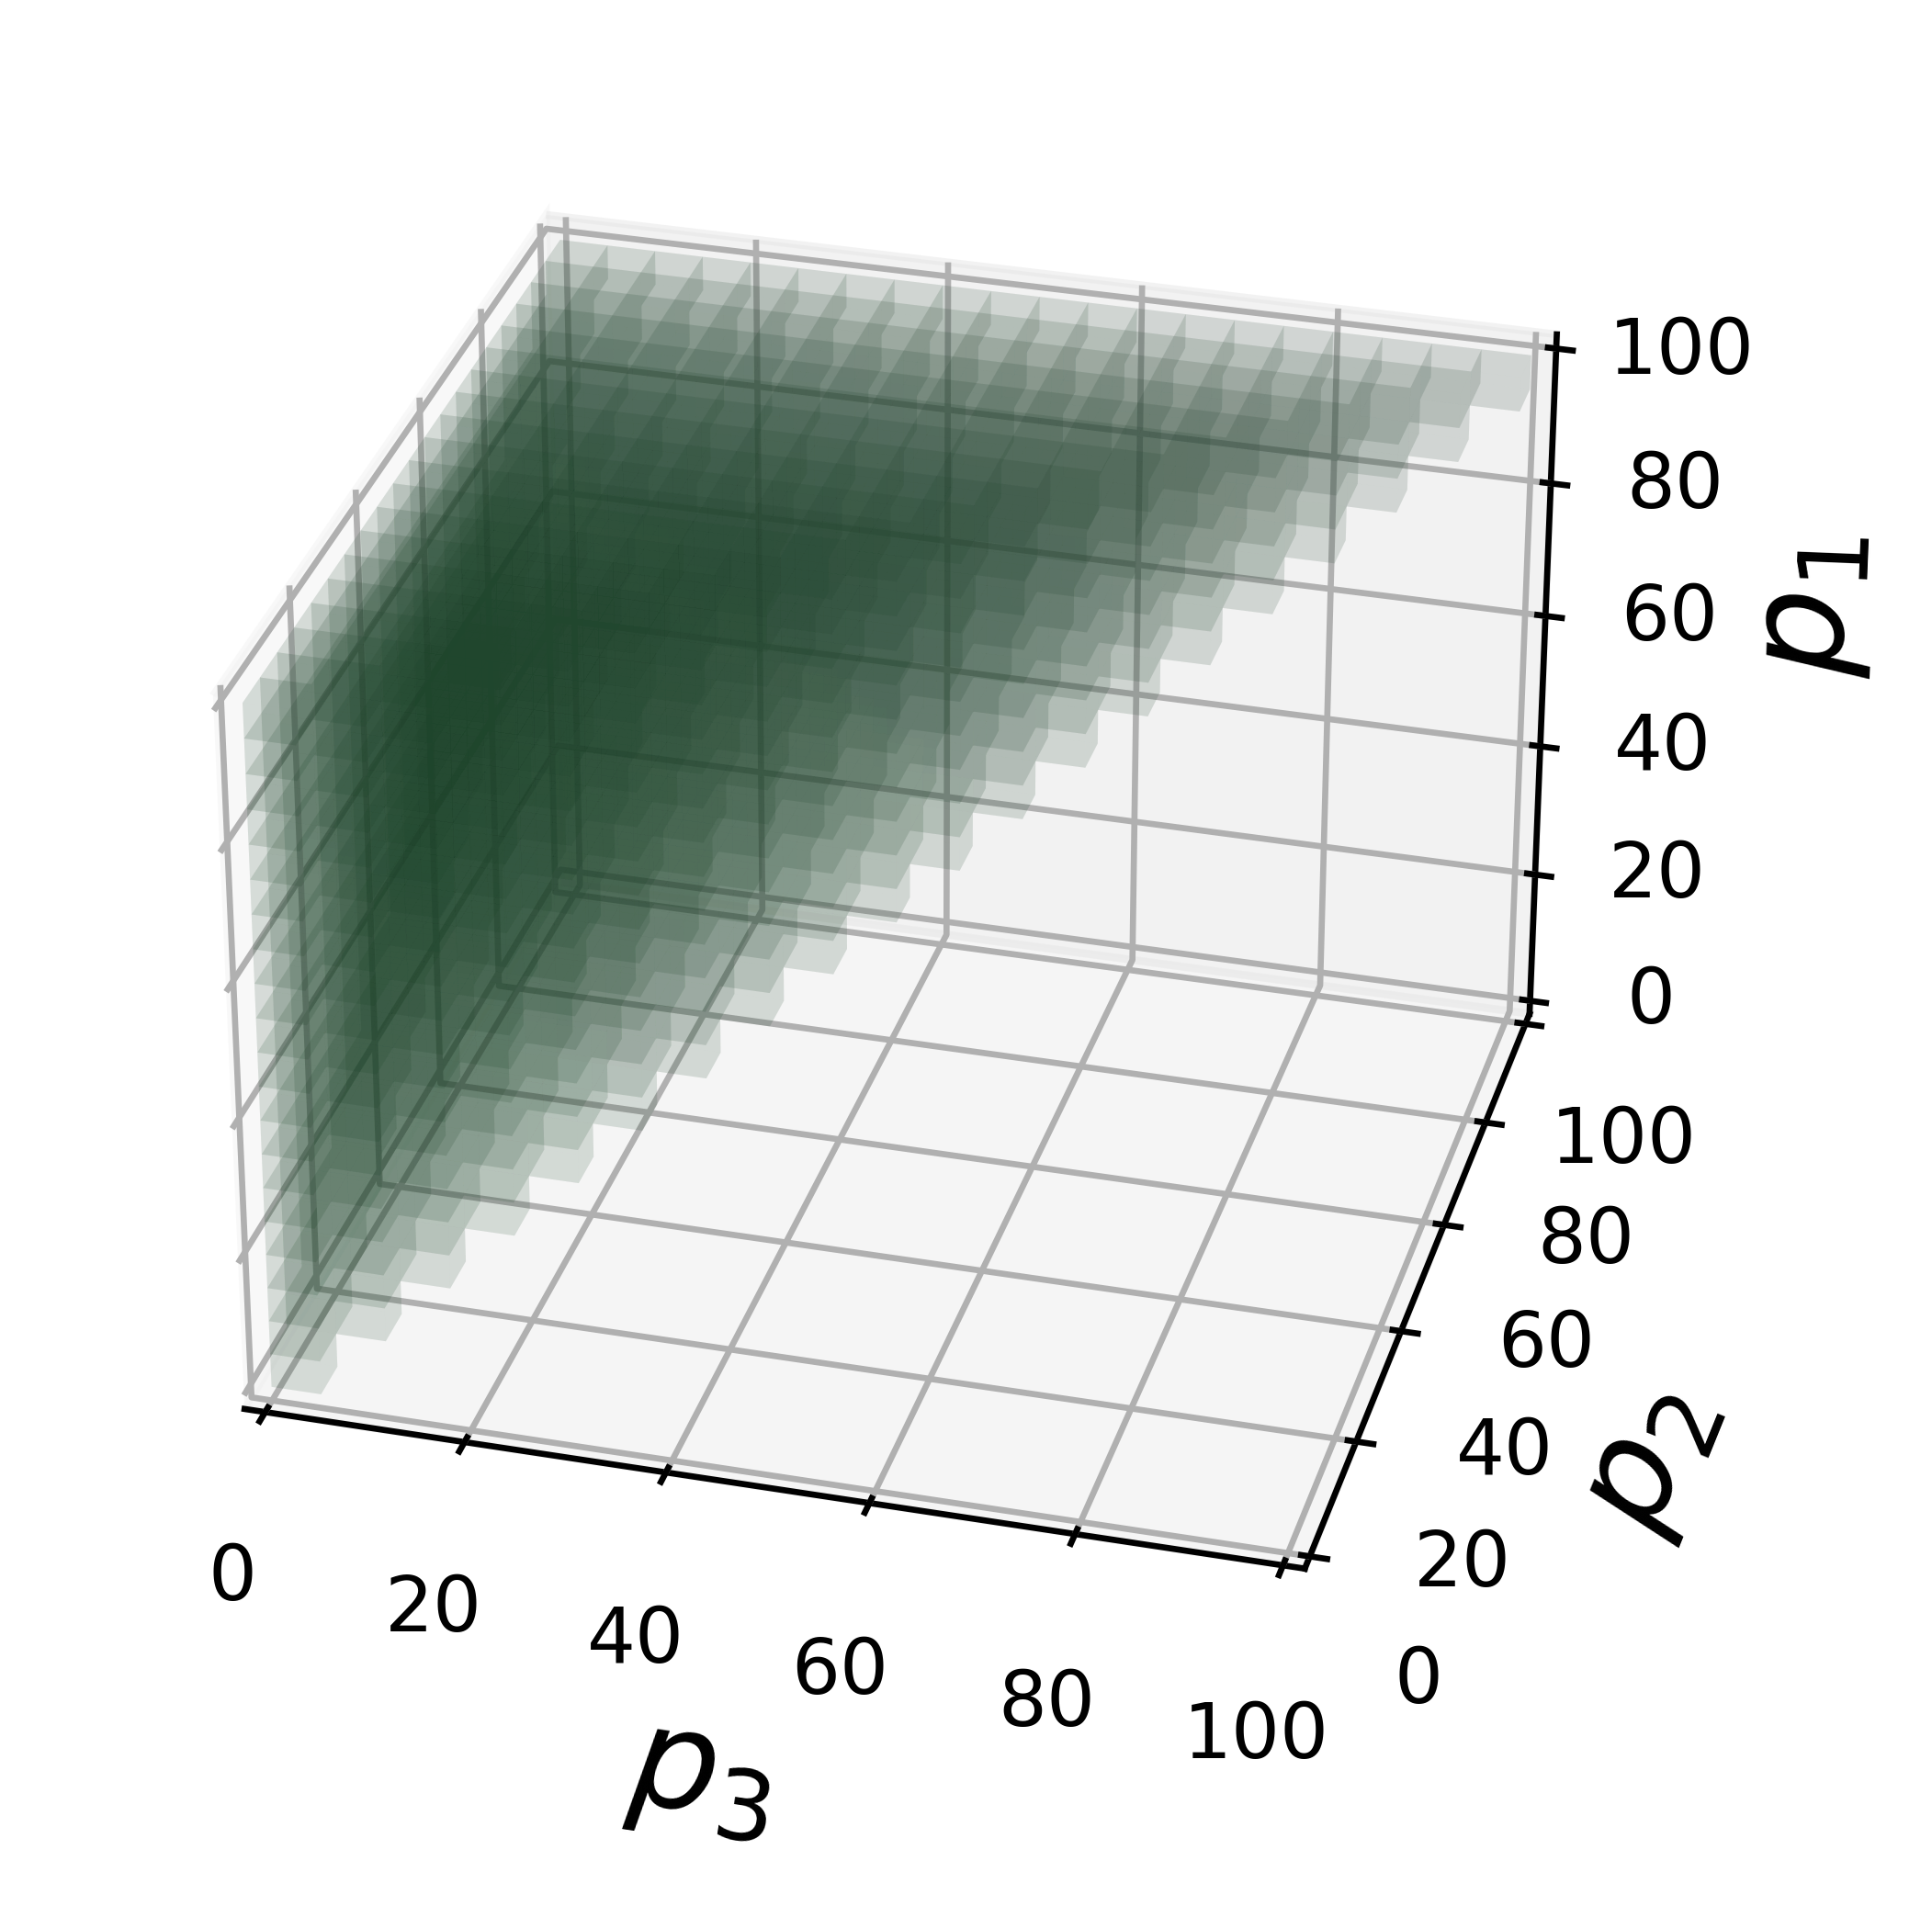

In [20]:
plot_cube(facecolors, stride = stride, angle=-75, name = f'{graph_type}_e{epoch}_s{s}', save=False)

In [ ]:
fig = plt.figure(figsize=(15, 6), dpi=200)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.plot(hp_dist)
ax2.plot(sp_dist)
ax3.plot(fp_dist)

In [38]:
pi_list[0]

array([0.82939297, 0.45551357, 0.8601324 , 0.32819748, 0.69894   ,
       0.80045545, 0.86906797, 0.34463966, 0.2776221 , 0.2527858 ,
       0.74070513, 0.21661796, 0.6324335 , 0.25444505, 0.19019246],
      dtype=float32)

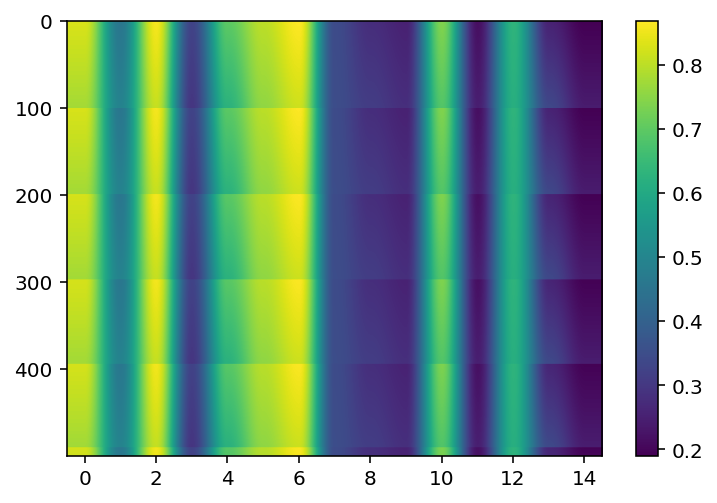

In [37]:
plt.imshow(pi_list[:500], aspect='auto')
plt.colorbar()

In [21]:
with open("data/runs/test_what/test_what_landscape_list.pkl", 'rb') as f:
    landscape_list = pickle.load(f)

In [35]:
sample = np.array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0])

In [24]:
land0 = landscape_list[0]

In [30]:
land0.get_global_max()[1]

0.1178195846102156

In [36]:
for i in range(5):
    print(landscape_list[i].get_value(sample) / landscape_list[i].get_global_max()[1])

0.03020315939819303
0.009481910668290997
0.047221805179164564
0.22143076638378117
0.0030059436388622


In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(111)
im_data = facecolors[0].transpose(1, 0, 2)
#im_data[..., -1] *= 2
ax.imshow(im_data, origin='lower', extent=[0, 100, 0, 100])
ax.set_xlabel(r'$p_2$', fontsize=30, labelpad=-70)
ax.set_ylabel(r'$p_1$', fontsize=30, labelpad=-85)
ax.set_xticks([0, 50, 100])
ax.set_yticks(np.arange(0, 100, 10))
ax.tick_params(axis = 'x', labelsize=24)
ax.tick_params(axis = 'y', labelsize=24)
#ax.vlines(50, 30, 100, lw=2, color='r', ls='--')
#ax.hlines(80, 0, 70, lw=2, color='darkblue', ls='--')
#ax.annotate(r'$\alpha = 50$', (55, 35), fontsize=24, color='r')
#ax.annotate(r'$\beta = 80$', (5, 87), fontsize=24, color='darkblue')
plt.tight_layout()
#plt.savefig('Fig2d1.svg', dpi=300)

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(111)
im_data = facecolors[:, :, -1].transpose(1, 0, 2)
#im_data[..., -1] *= 2
ax.imshow(im_data, origin='lower', extent=[0, 100, 0, 100])
ax.set_xlabel(r'$p_3$', fontsize=30, labelpad=-70)
ax.set_ylabel(r'$p_2$', fontsize=30, labelpad=-85)
ax.set_xticks([0, 50, 100])
ax.set_yticks([0, 50, 100])
ax.tick_params(axis = 'x', labelsize=24)
ax.tick_params(axis = 'y', labelsize=24)
plt.tight_layout()
#plt.savefig('Fig2e2.svg', dpi=300)

In [ ]:
# complete_L200 2025
# complete_L200_2 2269
# complete_L300 2593
# maxmc_L100 4483
# maxmc_L200 3761
exp_name = 'st_complete_indv_raw_full_total_random_SI_TT_N15K7NN3_new_rand200'
epoch = 2025
ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)

In [ ]:
# epoch
s = 50
epoch_list = [0]
max_s = 100

for epoch in epoch_list:
    
    exp_name = 'st_complete_indv_raw_full_total_random_SI_TT_N15K7NN3_new_rand200'
    ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
    print(epoch)
    
    template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
              [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

    tc = coord_triplet(max_s)
    data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0)
    tc = np.c_[np.ones(tc.shape[0])*s, tc]
    data[:, :, -2] = tc
    pi_list = []
    
    for i in range((data.shape[0]//10000)+1):
        a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
        x = pi.probs[..., 1].detach().cpu().numpy()
        pi_list.append(x)
    pi_list = np.concatenate(pi_list, axis=0)
    fp = fixed_point(ac)
    sp = template[0][:-2]
    hp = template[-1][:-2]
    facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, fp, sp, hp, True, False, True, max_s)
    stride = 5
    assert max_s%stride == 0
    facecolors = facecolors[::stride, ::stride, ::stride]
    plot_cube(facecolors, stride = stride, angle=-75, name = f'complete_e{epoch}_s{s}', save=True)

In [ ]:
def fixed_point_ce(ac):
    data = np.array([[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 99, 1], 
                  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 99, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 99, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 99, 0]]])

    pi = ac._distribution(torch.as_tensor(data, dtype=torch.float32, device='cuda'))
    x = pi.probs[..., 1].detach().cpu().numpy()
    return np.round(x)[0].astype(np.int)

# CEtest
s = 70
max_s = 100
epoch = ''

exp_name = 'st_complete_total_FollowBest_SI_N15K7NN3_CE_sptest'
seed = 42
obs_dim = (4, 17)
act_dim = (15, 2)
rel_path = f'data/runs/{exp_name}/{exp_name}_s{seed}/'
checkpoint = torch.load(rel_path+f'pyt_save/model{epoch}.pth')
ac_kwargs = {}
ac_kwargs['activation'] = nn.Tanh()
ac = core.SocialActor(obs_dim, act_dim, 'st', **ac_kwargs).cuda()
ac.logits_net.load_state_dict(checkpoint)
print(epoch)

template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

tc = coord_triplet(max_s)
data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0)
tc = np.c_[np.ones(tc.shape[0])*s, tc]
data[:, :, -2] = tc
pi_list = []

for i in range((data.shape[0]//5000)+1):
    pi = ac._distribution(torch.as_tensor(data[i*5000:(i+1)*5000], dtype=torch.float32, device='cuda'))
    x = pi.probs[..., 1].detach().cpu().numpy()
    pi_list.append(x)
pi_list = np.concatenate(pi_list, axis=0)
fp = fixed_point_ce(ac)
sp = template[0][:-2]
hp = template[-1][:-2]
facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, fp, sp, hp, True, False, True, max_s)
stride = 5
assert max_s%stride == 0
facecolors = facecolors[::stride, ::stride, ::stride]
plot_cube(facecolors, stride = stride, angle=-75, name = f'complete_e{epoch}_s{s}', save=False)

In [ ]:
epoch_list = np.arange(0, 3600, 50)

In [ ]:
writer.finish()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700


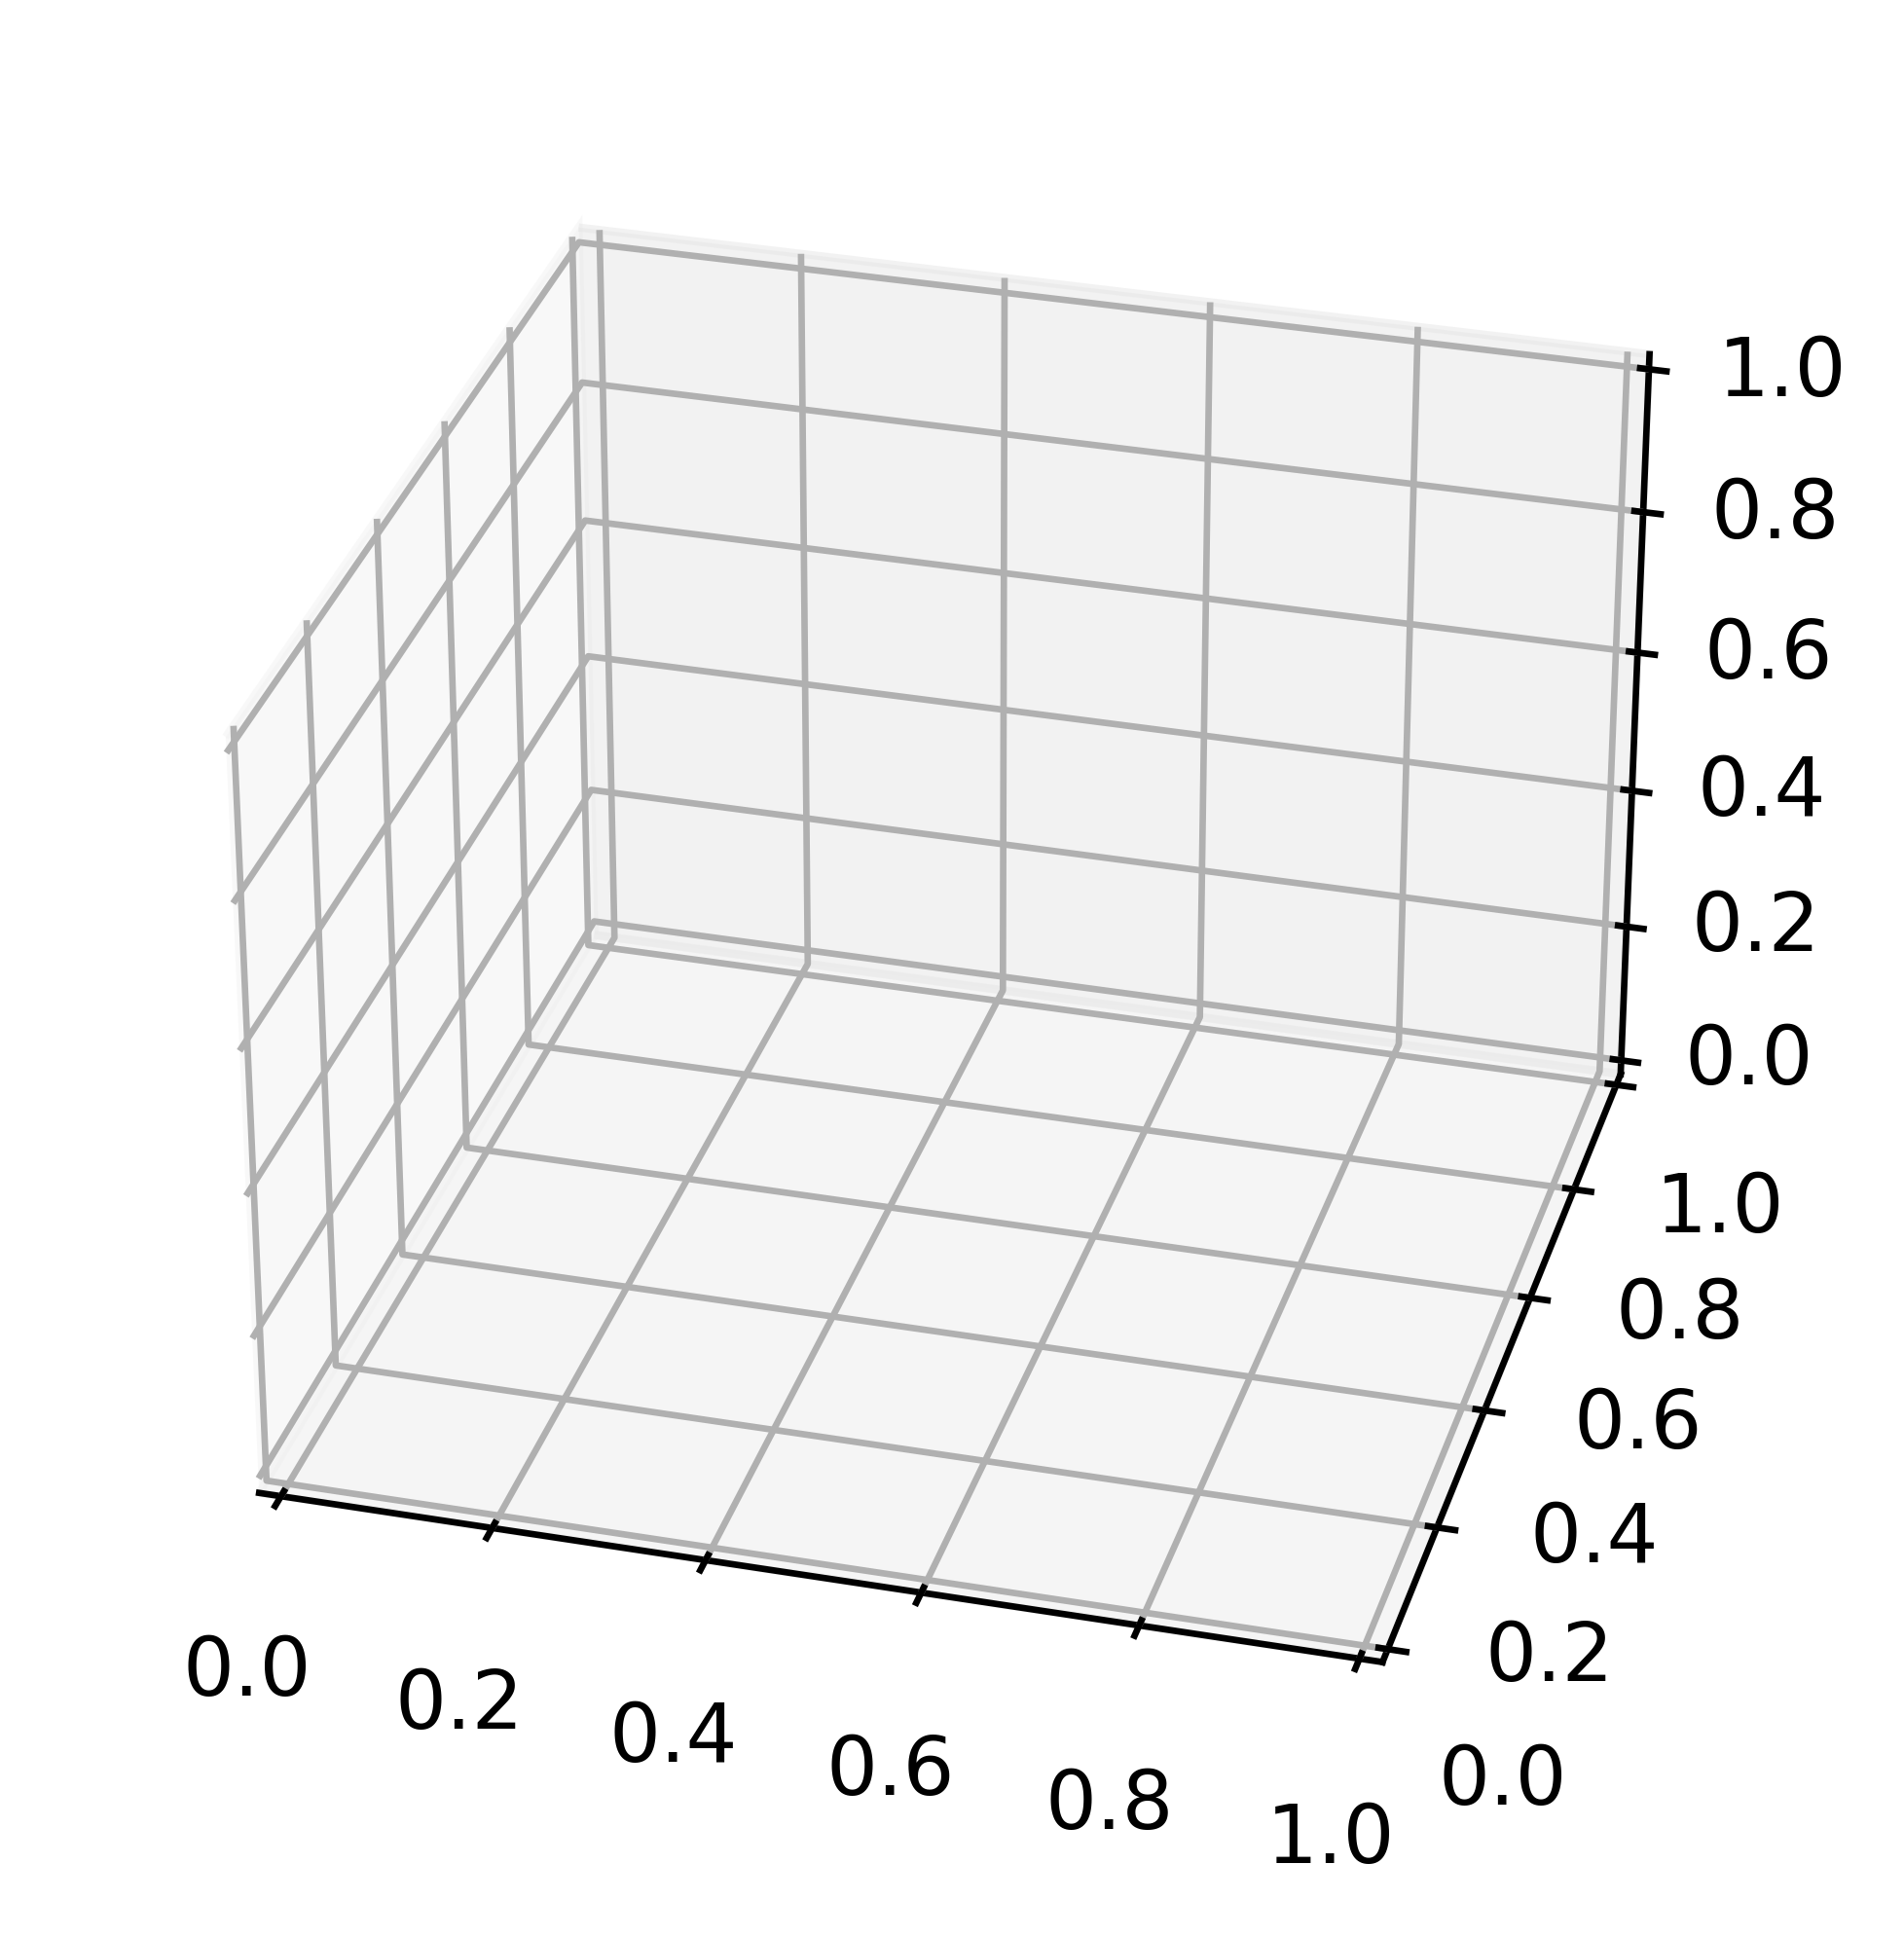

In [11]:
# animation
import matplotlib.animation as manimation

try:
    # self score
    max_s = 100
    s = 50
    epoch_list = np.arange(0, 5750, 50)
    graph_type = 'complete'
    exp_name = 'test_old6'
    label = 'old6'
    name = f'{graph_type}_s{s}_{label}'
    rescale = False
    
    fig = plt.figure(figsize=(4, 4), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, -75)
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title=f'test_{name}.mp4', artist='Matplotlib', comment='SocialNet')
    writer = FFMpegWriter(fps=10, metadata=metadata)
    writer.setup(fig, f'test_{name}.mp4', dpi=200)

    for epoch in epoch_list:
        ac, obs_dim, act_dim, dim_len, gamma, lam, env_kwargs = load_model(exp_name, epoch)
        print(epoch)
        template = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1], 
                  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, -1, 0]])

        tc = coord_triplet(max_s)
        data = np.repeat(template.reshape(1, 4, 17), len(tc), axis=0).astype(np.float)
        tc = np.c_[np.ones(tc.shape[0])*s, tc]
        if rescale:
            data[:, :, -2] = tc
        else:
            data[:, :, -2] = tc / 100.
        pi_list = []

        for i in range((data.shape[0]//10000)+1):
            a, v, logp, pi = ac.step(torch.as_tensor(data[i*10000:(i+1)*10000], dtype=torch.float32, device='cuda'), return_pi=True)
            x = pi.probs[..., 1].detach().cpu().numpy()
            pi_list.append(x)
        pi_list = np.concatenate(pi_list, axis=0)
        fp = fixed_point(ac)
        sp = template[0][:-2]
        hp = template[-1][:-2]
        facecolors, fp_dist, sp_dist, hp_dist = assign_facecolors(pi_list, fp, sp, hp, True, True, True, max_s)
        stride = 5
        assert max_s%stride == 0
        facecolors = facecolors[::stride, ::stride, ::stride]
        
        IMG_DIM = len(facecolors)
        facecolors = explode(facecolors)
        filled = facecolors[:,:,:,-1] != 0
        #print(filled.shape)
        #print(np.indices(np.array(filled.shape) + 1).shape)
        x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

        ax.set_xlim(right=IMG_DIM*stride)
        ax.set_ylim(top=IMG_DIM*stride)
        ax.set_zlim(top=IMG_DIM*stride)

        ax.set_xlabel(r'$p_3$', fontsize=18)
        ax.set_ylabel(r'$p_2$', fontsize=18)
        ax.set_zlabel(r'$p_1$', fontsize=18)
        #ax.set_xticklabels([])
        #ax.set_yticklabels([])
        #ax.set_zticklabels([])
        #ax.set_xticks([0, 50, 100])
        #ax.set_yticks([0, 50, 100])
        #ax.set_zticks([0, 50, 100])
        #ax.tick_params(axis = 'x', labelsize=12)
        #ax.tick_params(axis = 'y', labelsize=12)
        #ax.tick_params(axis = 'z', labelsize=12)

        ax.voxels(x/2*stride, y/2 * stride, z/2 * stride, filled, facecolors=facecolors, shade=False)
        writer.grab_frame(facecolor='w')
        ax.clear()
    writer.finish()
    
except KeyboardInterrupt:
    writer.finish()

## Fig.3

### Fig. 3a

In [ ]:
with open(f'./data/baseline_data/baseline_complete_N15K7NN3.pkl', 'rb') as f:
    baseline_complete_dict = pickle.load(f)
with open('./result/inspection_dict/inspection_dict_complete_N15K7NN3L200.pkl', 'rb') as f:
    inspection_complete_dict = pickle.load(f)
with open(f'./data/baseline_data/baseline_complete_N15K7NN3L200_RL.pkl', 'rb') as f:
    inspired_complete_dict = pickle.load(f)

In [ ]:
complete_dict = {}
complete_sem_dict = {}
for key in baseline_complete_dict.keys():
    if key != 'keys':
        #print(key)
        result = []
        np.mean(baseline_complete_dict[key]['scr_buf'])
        complete_dict[conversion_dict1[key]] = [np.mean(baseline_complete_dict[key]['scr_buf']), 
                                                     np.mean(baseline_complete_dict[key]['scr_buf'][..., -1])]
        complete_sem_dict[conversion_dict1[key]] = [np.std(np.mean(baseline_complete_dict[key]['scr_buf'], axis=(-2, -1)))/np.sqrt(1000), 
                                                     np.std(np.mean(baseline_complete_dict[key]['scr_buf'][..., -1], axis=-1))/np.sqrt(1000)]

In [ ]:
Ret_list = []
FinalScore_list = []

for i in range(len(inspection_complete_dict['buf_list'])):
    Ret_list.append(inspection_complete_dict['buf_list'][i].scr_buf)
    FinalScore_list.append(inspection_complete_dict['buf_list'][i].scr_buf[:, :, -1])
    
Ret_list = np.array(Ret_list)
FinalScore_list = np.array(FinalScore_list)

In [ ]:
plt.plot(sp_dist)

In [ ]:
complete_dict['RL-C'] = [np.mean(Ret_list), 
                                np.mean(FinalScore_list)]
complete_dict['RLI-C'] = [np.mean(inspired_complete_dict['50SF']['scr_buf']), 
                                 np.mean(inspired_complete_dict['50SF']['scr_buf'][..., -1])]
complete_sem_dict['RL-C'] = [np.std(np.mean(Ret_list, axis=(-2, -1)))/np.sqrt(1000), 
                                    np.std(np.mean(FinalScore_list, axis=-1))/np.sqrt(1000)]
complete_sem_dict['RLI-C'] = [np.std(np.mean(inspired_complete_dict['50SF']['scr_buf'], axis=(-2, -1)))/np.sqrt(1000), 
                                     np.std(np.mean(inspired_complete_dict['50SF']['scr_buf'][..., -1], axis=-1))/np.sqrt(1000)]

In [ ]:
del baseline_complete_dict, inspection_complete_dict, inspired_complete_dict

In [ ]:
# values
# https://par.nsf.gov/servlets/purl/10174175
complete_dict = {'BI': [31.316404351416814, 31.535823172057643],
 'BI-I': [55.65659766305655, 56.533095293803555],
 'BI-R' : [80.5, 90.5]
 'CF': [4.331272459061714, 4.395733020980512],
 'CF-I': [64.77072175303823, 78.64372833106057],
 'CF-R' : [49.015683766891793,72.03867701655563]
 'PI': [32.76666553307289, 35.955548569108615],
 'PI-R' : [32.49278498069034, 41.21528546371035]
 'RI': [31.016038793926015, 31.535823172057643],
 'RL-C': [61.052296, 77.39863],
 'RLI-C': [81.69471491586457, 86.72906711039693]}

complete_sem_dict = {'BI': [0.460220335667514, 0.4648158762548385],
 'BI-I': [0.674005783699493, 0.6903653207158427],
 'CF': [0.050763713719949866, 0.05709763832407791],
 'CF-I': [0.50060945056812, 0.6407058095480598],
 'PI': [0.23463281694631358, 0.2539470824219625],
 'RI': [0.454239977690918, 0.4648158762548385],
 'RL-C': [0.5296942949980635, 0.5231485983429406],
 'RLI-C': [0.3991087806627622, 0.42788146139584066]}

In [ ]:
#N15K0
Baseline : FollowBest
FollowBest, 0.7701881718327646, 0.7739212275824013
Baseline : FollowBest_indv
FollowBest_indv, 0.9901181566187446, 1.0
Baseline : FollowBest_random
FollowBest_random, 0.9580521702000137, 0.9888723938087037
Baseline : FollowMajor
FollowMajor, 0.18403283261876946, 0.18771895426129193
Baseline : FollowMajor_indv
FollowMajor_indv, 0.9433224887722131, 1.0
Baseline : FollowMajor_random
FollowMajor_random, 0.8265267775096279, 0.9538551193397692

In [ ]:
# N!5K3
Baseline : FollowBest
FollowBest, 0.45240181886763786, 0.4554191768658337
Baseline : FollowBest_indv
FollowBest_indv, 0.8206168439996225, 0.8331015013300008
Baseline : FollowBest_random
FollowBest_random, 0.8547654362049473, 0.9255553479487247
Baseline : FollowMajor
FollowMajor, 0.06807922943134297, 0.06923327015190527
Baseline : FollowMajor_indv
FollowMajor_indv, 0.8546830411354608, 0.9681604761612455
Baseline : FollowMajor_random
FollowMajor_random, 0.5985725688225696, 0.8092960438291436

In [ ]:
#N15K12
Baseline : FollowBest
FollowBest, 0.37495779417821057, 0.3776001132383657
Baseline : FollowBest_indv
FollowBest_indv, 0.4630107049331981, 0.4676475797124229
Baseline : FollowBest_random
FollowBest_random, 0.784411567798735, 0.9059264031730423
Baseline : FollowMajor
FollowMajor, 0.055149866554035996, 0.05625603944792885
Baseline : FollowMajor_indv
FollowMajor_indv, 0.42022330941703157, 0.49686442603748326
Baseline : FollowMajor_random
FollowMajor_random, 0.533348373804119, 0.78305432324615

In [ ]:
#N20K15


In [ ]:
plt.plot(hp_dist)

In [ ]:
plt.plot(sp_dist)

In [ ]:
plt.plot(sp_dist)

In [ ]:
plt.plot(fp_dist)

In [ ]:
plt.plot(fp_dist)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8,4), dpi=300)
ax = fig.add_subplot(111)

labels = ['Average', 'Final']
color_list = ['#98042D', '#FF0F39', '#F16745', '#FFC65D', '#7BC8A4', '#4CC3D9', '#93648D', '#747474'] 
center  = np.array([0., 3.])
width = 0.175
length = len(complete_dict)

if length%2: 
    start = -(length//2)*width
else: 
    start = -((length//2)-0.5)*width
offset = [start + i * width for i in range(length)]
offset[0] -= width/2
offset[1] -= width/2

order_dict = ['RLI-C', 'RL-C', 'CF-I', 'BI-I', 'PI', 'RI', 'BI', 'CF']

for i, key in enumerate(order_dict):
    ax.bar(center+offset[i], complete_dict[key], width, label=key, color = color_list[i], yerr=2*np.array(complete_sem_dict[key]))
#BI_rect = ax.bar(x - width/2, con, width, label='CN', color = 'salmon')
#BI_rect = ax.bar(x + width/2, siam, width, label='SNN', color = 'skyblue')

ax.set_ylabel('Mean Payoff', fontsize=18)
ax.set_xticks(center-width/2)
ax.set_xticklabels(labels, fontsize=18)
ax.tick_params(axis = 'y', labelsize=12)
ax.legend(loc=8, ncol=2, fontsize=10)
best_baseline = 'CF-I'
ax.hlines(complete_dict[best_baseline][0], center[0] + offset[0]-width, center[0] + offset[5], ls=(0, (3, 2)), color='#444444', lw=1.5)
ax.hlines(complete_dict[best_baseline][1], center[1] + offset[0]-width, center[1] + offset[5], ls=(0, (3, 2)), color='#444444', lw=1.5)

plt.tight_layout()
plt.savefig('Fig3a.svg', transparent=True, dpi=300)

### Fig. 3b

In [ ]:
# Figure drawing
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#F16745', '#FFC65D', '#7BC8A4', '#4CC3D9', '#93648D', '#747474', '#98042D', '#FF0F39']
counter=0
order_dict = ['CF-I', 'BI-I', 'PI', 'RI', 'BI', 'CF', 'RLI-C', 'RL-C']
for baseline_name in order_dict:
    if baseline_name == 'RLI-C':
        x = inspired_complete_dict['50SF']['scr_buf'][..., :200]
        ls = '-'
        lw = 3
    elif baseline_name == 'RL-C':
        x = np.array([inspection_complete_dict['buf_list'][i].scr_buf for i in range(len(inspection_complete_dict['buf_list']))])
        ls = '-'
        lw = 3
    else:
        x = baseline_complete_dict[conversion_dict2[baseline_name]]['scr_buf']
        ls = (0, (2, 1.5))
        lw = 2
    avg_pf = np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
    std_pf = np.std(x, axis=tuple(range(0, len(x.shape) - 1)))
    ax.plot(np.arange(x.shape[-1]), avg_pf, c=color_list[counter], label=baseline_name, ls=ls, lw=lw)
    #ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.2)
    counter+=1

ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Average Payoff', fontsize=18)
ax.tick_params(axis = 'both', labelsize=12)

handles, labels = ax.get_legend_handles_labels()
order = [6, 7, 0, 1, 2, 3, 4, 5]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=10, ncol=2, loc=4)
plt.tight_layout()
plt.savefig('Fig3b.svg', transparent=True, dpi=300)

### Fig. 3c

In [ ]:
baseline_tweak_data_dict = {}
for i in range(5):
    with open(f'./baseline_complete_tweak{i+1}_N15K7NN3L200_RL.pkl', 'rb') as f:
        new_dict = pickle.load(f)
    if baseline_tweak_data_dict:
        baseline_tweak_data_dict.update(new_dict)
    else:
        baseline_tweak_data_dict = new_dict

In [ ]:
avg_list = []
final_list = []
for key in baseline_tweak_data_dict.keys():
    if key != 'keys':
        avg_list.append(baseline_tweak_data_dict[key]['Ret'])
        final_list.append(baseline_tweak_data_dict[key]['FinalScore'])
avg_list = np.array(avg_list).reshape(5, 5).T
final_list = np.array(final_list).reshape(5, 5).T

In [ ]:
avg_list = np.array([[59.59153294, 63.10249743, 62.35156236, 63.23449583, 62.94157512],
       [59.06210007, 64.91382124, 72.85451338, 74.49451458, 74.75822029],
       [64.0277052 , 66.59218581, 77.04678169, 81.61730786, 81.10904179],
       [61.00603022, 65.66198893, 75.30509986, 79.83156241, 73.81842869],
       [55.74778484, 64.52121474, 76.59301148, 81.35825666, 58.44308177]]).T

In [ ]:
fig = plt.figure(figsize=(4.5, 4.5), dpi=300)
ax = fig.add_subplot(111)

im = ax.imshow(avg_list, origin='lower', vmin=59)
ax.set_xlabel(r'$\alpha$', fontsize=18)
ax.set_xticklabels(['0', '10', '30', '50', '70', '90'])
ax.set_ylabel(r'$\beta$', fontsize=18)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])

ax.tick_params(axis = 'both', labelsize=12)
ax.text(1.63, 3, 'RLI-M', fontsize=12, color='blue')
ax.text(1.63, 4, 'RLI-C', fontsize=12, color='red')
ax.text(1.67, 2.80, '(81.61)', fontsize=8, color='blue')
ax.text(1.67, 3.80, '(81.10)', fontsize=8, color='red')


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.savefig('Fig3c.svg', transparent=True, dpi=300)

In [ ]:
checkpoint = ('', -1)
if checkpoint[0]:
    print('yes')

In [ ]:
facecolors.shape

### Fig. 3d

In [ ]:
test = pi.probs.reshape(17, 100, 15, 2)[..., 1]

In [ ]:
test.shape

In [ ]:
1/torch.mean(torch.std(torch.mean(test, dim=1), dim=0)) * 1e-10

In [ ]:
plt.imshow((torch.mean(test, dim=1)).cpu().numpy())

In [ ]:
with open(f'./data/baseline_data/baseline_maxmc_N15K7NN3.pkl', 'rb') as f:
    baseline_maxmc_dict = pickle.load(f)
with open('./result/inspection_dict/inspection_dict_maxmc_N15K7NN3L200.pkl', 'rb') as f:
    inspection_maxmc_dict = pickle.load(f)
with open(f'./data/baseline_data/baseline_maxmc_N15K7NN3L200_RL.pkl', 'rb') as f:
    inspired_maxmc_dict = pickle.load(f)

In [ ]:
maxmc_dict = {}
maxmc_sem_dict = {}
for key in baseline_maxmc_dict.keys():
    if key != 'keys':
        #print(key)
        result = []
        np.mean(baseline_maxmc_dict[key]['scr_buf'])
        maxmc_dict[conversion_dict1[key]] = [np.mean(baseline_maxmc_dict[key]['scr_buf']), 
                                                     np.mean(baseline_maxmc_dict[key]['scr_buf'][..., -1])]
        maxmc_sem_dict[conversion_dict1[key]] = [np.std(np.mean(baseline_maxmc_dict[key]['scr_buf'], axis=(-2, -1)))/np.sqrt(1000), 
                                                     np.std(np.mean(baseline_maxmc_dict[key]['scr_buf'][..., -1], axis=-1))/np.sqrt(1000)]

In [ ]:
checkpoint

In [ ]:
type(ac)

In [ ]:
plt.imshow(pi_list, aspect='auto')

In [ ]:
plt.imshow(pi_list, aspect='auto')

In [ ]:
plt.imshow(pi_list, aspect='auto')

In [ ]:
Ret_list = []
FinalScore_list = []

for i in range(len(inspection_maxmc_dict['buf_list'])):
    Ret_list.append(inspection_maxmc_dict['buf_list'][i].scr_buf)
    FinalScore_list.append(inspection_maxmc_dict['buf_list'][i].scr_buf[:, :, -1])
    
Ret_list = np.array(Ret_list)
FinalScore_list = np.array(FinalScore_list)

In [ ]:
maxmc_dict['RL-M'] = [np.mean(Ret_list), 
                                np.mean(FinalScore_list)]
maxmc_dict['RLI-M'] = [np.mean(inspired_complete_dict['50SF']['scr_buf']), 
                                 np.mean(inspired_maxmc_dict['50SF']['scr_buf'][..., -1])]
maxmc_sem_dict['RL-M'] = [np.std(np.mean(Ret_list, axis=(-2, -1)))/np.sqrt(1000), 
                                    np.std(np.mean(FinalScore_list, axis=-1))/np.sqrt(1000)]
maxmc_sem_dict['RLI-M'] = [np.std(np.mean(inspired_maxmc_dict['50SF']['scr_buf'], axis=(-2, -1)))/np.sqrt(1000), 
                                     np.std(np.mean(inspired_complete_dict['50SF']['scr_buf'][..., -1], axis=-1))/np.sqrt(1000)]

In [ ]:
plot_cube(facecolors, stride = stride, angle=-75, name = f'complete_e{epoch}_s{s}', save=False)

In [ ]:
stride = 5
assert max_s%stride == 0
facecolors = facecolors[::stride, ::stride, ::stride]

In [ ]:
maxmc_sem_dict

In [ ]:
facecolors[0].transpose(1, 0, 2)

In [ ]:
im_data

In [ ]:
im_data[..., -1]

In [ ]:
# values
maxmc_dict = {'BI': [31.58477693809629, 32.471041315814574],
 'BI-I': [65.1695585710008, 67.61616710838432],
 'CF': [4.413471361265432, 4.414456355223335],
 'CF-I': [43.470540327603, 51.65049517143568],
 'PI': [33.68311735626813, 36.9174909262063],
 'RI': [30.434319638441604, 32.471041315814574],
 'RL-M': [63.704597, 72.90024],
 'RLI-M': [81.69471491586457, 86.72906711039693]}

In [ ]:
maxmc_sem_dict = {'BI': [0.3967722726366467, 0.4160445131763879],
 'BI-I': [0.5975579166876599, 0.6341385198867582],
 'CF': [0.027759639645980463, 0.02781303219888053],
 'CF-I': [0.29039263885895444, 0.42599514945385253],
 'PI': [0.1477662490586973, 0.16129909268241174],
 'RI': [0.37367140512288216, 0.4160445131763879],
 'RL-M': [0.4635525949198967, 0.4184346719818216],
 'RLI-M': [0.5590854525058797, 0.42788146139584066]}

In [ ]:
data = np.random.rand(10,10)

In [ ]:
fig, ax2 = plt.subplots()

ax2.imshow(data, extent=[-300,300, 450, 50])

plt.show()

In [ ]:
fig, ax2 = plt.subplots()

ax2.imshow(data, extent=[-300,300, 50, 450])

plt.show()

In [ ]:
x

In [ ]:
x

In [ ]:
facecolors[15]

In [ ]:
facecolors

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8,4), dpi=300)
ax = fig.add_subplot(111)

labels = ['Average', 'Final']
color_list = ['#041F60', '#0476D0', '#F16745', '#FFC65D', '#7BC8A4', '#4CC3D9', '#93648D', '#747474'] 

center  = np.array([0., 3.])
width = 0.175
length = len(maxmc_dict)

if length%2: 
    start = -(length//2)*width
else: 
    start = -((length//2)-0.5)*width
offset = [start + i * width for i in range(length)]
offset[0] -= width/2
offset[1] -= width/2

order_dict = ['RLI-M', 'RL-M', 'CF-I', 'BI-I', 'PI', 'RI', 'BI', 'CF']

for i, key in enumerate(order_dict):
    ax.bar(center+offset[i], maxmc_dict[key], width, label=key, color = color_list[i], yerr=2*np.array(maxmc_sem_dict[key]))
        
#BI_rect = ax.bar(x - width/2, con, width, label='CN', color = 'salmon')
#BI_rect = ax.bar(x + width/2, siam, width, label='SNN', color = 'skyblue')

ax.set_ylabel('Mean Payoff', fontsize=18)
ax.set_xticks(center-width/2)
ax.set_xticklabels(labels, fontsize=18)
ax.tick_params(axis = 'y', labelsize=12)
ax.legend(loc=8, ncol=2, fontsize=10)
best_baseline = 'BI-I'
ax.hlines(maxmc_dict[best_baseline][0], center[0] + offset[0]-width, center[0] + offset[5], ls=(0, (3, 2)), color='#444444', lw=1.5)
ax.hlines(maxmc_dict[best_baseline][1], center[1] + offset[0]-width, center[1] + offset[5], ls=(0, (3, 2)), color='#444444', lw=1.5)

plt.tight_layout()
plt.savefig('Fig3d.svg', transparent=True, dpi=300)

### Fig. 3e

In [ ]:
# Figure drawing
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#F16745', '#FFC65D', '#7BC8A4', '#4CC3D9', '#93648D', '#747474', '#041F60', '#0476D0']   
counter=0
order_dict = ['CF-I', 'BI-I', 'PI', 'RI', 'BI', 'CF', 'RLI-M', 'RL-M']
for baseline_name in order_dict:
    if baseline_name == 'RLI-M':
        x = inspired_maxmc_dict['50SF80']['scr_buf'][..., :200]
        ls = '-'
        lw = 3
    elif baseline_name == 'RL-M':
        x = np.array([inspection_maxmc_dict['buf_list'][i].scr_buf for i in range(len(inspection_maxmc_dict['buf_list']))])
        ls = '-'
        lw = 3
    else:
        x = baseline_maxmc_dict[conversion_dict2[baseline_name]]['scr_buf']
        ls = (0, (2, 1.5))
        lw = 2
    avg_pf = np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
    std_pf = np.std(x, axis=tuple(range(0, len(x.shape) - 1)))
    ax.plot(np.arange(x.shape[-1]), avg_pf, c=color_list[counter], label=baseline_name, ls=ls, lw=lw)
    #ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.2)
    counter+=1

ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Mean Payoff', fontsize=18)
ax.tick_params(axis = 'both', labelsize=12)

handles, labels = ax.get_legend_handles_labels()
order = [6, 7, 0, 1, 2, 3, 4, 5]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=10, ncol=2,loc=4)
plt.tight_layout()
plt.savefig('Fig3e.svg', transparent=True, dpi=300)

### Fig. 3f

In [ ]:
baseline_tweak_data_dict = {}
for i in range(5):
    with open(f'./baseline_maxmc_tweak{i+1}_N15K7NN3L200_RL.pkl', 'rb') as f:
        new_dict = pickle.load(f)
    if baseline_tweak_data_dict:
        baseline_tweak_data_dict.update(new_dict)
    else:
        baseline_tweak_data_dict = new_dict

In [ ]:
avg_list = []
final_list = []
for key in baseline_tweak_data_dict.keys():
    if key != 'keys':
        avg_list.append(baseline_tweak_data_dict[key]['Ret'])
        final_list.append(baseline_tweak_data_dict[key]['FinalScore'])
avg_list = np.array(avg_list).reshape(5, 5).T
final_list = np.array(final_list).reshape(5, 5)

In [ ]:
avg_list = np.array([[63.22695257, 65.46108704, 65.43210202, 65.23944669, 65.00176105],
       [69.84276739, 73.70376158, 76.53554874, 77.31926316, 77.5453355 ],
       [69.67151559, 72.91732843, 79.00359567, 81.64231783, 76.60867024],
       [66.84296367, 71.4652598 , 77.62312583, 78.66669711, 50.99778514],
       [70.21095056, 73.57026321, 79.7488304 , 80.98365346, 42.65576531]]).T

In [ ]:
fig = plt.figure(figsize=(4.5, 4.5), dpi=300)
ax = fig.add_subplot(111)

im = ax.imshow(avg_list, origin='lower', vmin=59)
ax.set_xlabel(r'$\alpha$', fontsize=18)
ax.set_xticklabels(['0', '10', '30', '50', '70', '90'])
ax.set_ylabel(r'$\beta$', fontsize=18)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])

ax.tick_params(axis = 'both', labelsize=12)
ax.text(1.63, 3, 'RLI-M', fontsize=12, color='blue')
ax.text(1.63, 4, 'RLI-C', fontsize=12, color='red')
ax.text(1.67, 2.80, '(81.64)', fontsize=8, color='blue')
ax.text(1.67, 3.80, '(76.61)', fontsize=8, color='red')


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.savefig('Fig3f.svg', transparent=True, dpi=300)

### props

In [ ]:
import networkx as nx
from utils.utils import max_mean_clustering_network

In [ ]:
G = nx.complete_graph(100)
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
nx.draw_networkx(G, pos = nx.nx_pydot.graphviz_layout(G), ax = ax, with_labels=False, 
                 node_size=30, node_color = '#0476D0',
                width=1, edge_color='#0476D0', edgecolors='k')
plt.axis('off')
plt.savefig('complete_network.png', dpi=150, transparent=True)

In [ ]:
G = max_mean_clustering_network(100)
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
nx.draw_networkx(G, pos = nx.nx_pydot.graphviz_layout(G), ax = ax, with_labels=False, 
                 node_size=30, node_color = '#43B0F1',
                width=1, edge_color='#43B0F1', edgecolors='k')
plt.axis('off')
plt.savefig('maxmc_network.png', dpi=150, transparent=True)
# '#041F60', '#0476D0', 

In [ ]:
facecolors

## Figure 4

In [ ]:
facecolors[0].shape

In [ ]:
with open('OLP_updated.pickle', 'rb') as f:
    real_network_data = pickle.load(f)
candidate = {}
max_node_threshold = 1200
here = 0

for network_index in (real_network_data.network_index):
    graph = nx.Graph()
    graph.add_edges_from([tuple(x) for x in real_network_data[real_network_data['network_index']==network_index]['edges_id'].values[0]]) # add weights to the edges
    graph2 = nx.k_core(graph, k=3)
    if graph2.number_of_nodes() > 0 and graph2.number_of_nodes()/graph.number_of_nodes() > 0.95:
        candidate[network_index] = graph2.number_of_nodes()
        
network_data = real_network_data[np.isin(real_network_data['network_index'], list(candidate.keys()))]
network_filter = np.logical_and(network_data['networkDomain'] == 'Social', network_data['number_nodes'].values < max_node_threshold )
network_data = network_data[network_filter]

In [ ]:
network_index = network_data.network_index.values
network_nodes = np.array([candidate[i] for i in network_index])

network_nodes = network_nodes.reshape(20, 5).T
network_index = network_index.reshape(20, 5).T

In [ ]:
avg_pf_dict = {}
mean_dict = {}
sem_dict = {}
diameter_dict = {}
baseline_names = ['CF', 'CF-I', 'BI', 'BI-I', 'RI', 'PI', 'RLI-C', 'RLI-M']
not_connected = [18, 19, 37, 38, 39, 58, 59, 78, 79, 97, 98, 99]
diameter_dict = {0: 4, 1: 7, 2: 14, 3: 18, 4: 17, 5: 16, 6: 17, 7: 15, 8: 14, 9: 12, 10: 14, 11: 18, 12: 20, 13: 16, 14: 14, 15: 15, 16: 14, 17: 17, 20: 4, 21: 7, 22: 14, 23: 17, 24: 17, 25: 16, 26: 17, 27: 15, 28: 13, 29: 12, 30: 15, 31: 18, 32: 20, 33: 14, 34: 15, 35: 15, 36: 15, 40: 3, 41: 7, 42: 14, 43: 13, 44: 17, 45: 20, 46: 17, 47: 15, 48: 13, 49: 14, 50: 14, 51: 18, 52: 20, 53: 14, 54: 13, 55: 15, 56: 17, 57: 14, 60: 4, 61: 21, 62: 17, 63: 14, 64: 17, 65: 18, 66: 15, 67: 15, 68: 12, 69: 15, 70: 15, 71: 18, 72: 19, 73: 14, 74: 14, 75: 15, 76: 18, 77: 15, 80: 7, 81: 16, 82: 17, 83: 16, 84: 16, 85: 14, 86: 15, 87: 15, 88: 12, 89: 15, 90: 20, 91: 18, 92: 17, 93: 14, 94: 17, 95: 15, 96: 17}
for ci, ni in enumerate(network_index.flatten()):
    print(ci, ni)
    if ci not in not_connected:
        avg_pf_dict[ci] = {}
        mean_dict[ci] = {}
        sem_dict[ci] = {}
        with open(f'real_network_{ci}.pkl', 'rb') as f:
            data = pickle.load(f)
        for baseline_name in baseline_names:
            x = data[conversion_dict2[baseline_name]]['scr_buf']
            avg_pf_dict[ci][baseline_name] = np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
            mean_dict[ci][baseline_name] = [np.mean(x), np.mean(x[..., -1])]
            sem_dict[ci][baseline_name] = [np.mean(x, axis=(-2, -1)), np.mean(x[..., -1], axis=-1)]
            #diameter_dict[ci] = nx.algorithms.distance_measures.diameter(nx.k_core(real_network(network_data, network_index=ni), k=3))
        del data

In [ ]:
complete_dict = {}
complete_sem_dict = {}
for baseline_name in baseline_names:
    result = []
    sem_result = []
    for i in mean_dict.keys():
        result.append(mean_dict[i][baseline_name])
        sem_result.append(sem_dict[i][baseline_name])
    result = np.mean(np.array(result), axis=0)
    sem_result = np.std(np.array(sem_result).transpose(1, 0, 2, 3).reshape(2, -1), axis=1)/np.sqrt(100)
    complete_dict[baseline_name] = list(result)
    complete_sem_dict[baseline_name] = list(sem_result)


In [ ]:
# values
complete_dict = {'CF': [4.5055027, 4.5116773],
 'CF-I': [42.62009, 51.61013],
 'BI': [47.111904, 48.562035],
 'BI-I': [83.06336, 86.41762],
 'RI': [45.249554, 48.562035],
 'PI': [34.570377, 37.884],
 'RLI-C': [75.618706, 88.270004],
 'RLI-M': [89.892456, 97.35261]}

complete_sem_dict = {'CF': [0.08574654, 0.08778675],
 'CF-I': [0.8353921, 1.0933863],
 'BI': [1.6102298, 1.691082],
 'BI-I': [1.5388819, 1.6383806],
 'RI': [1.5103414, 1.691082],
 'PI': [0.5258732, 0.5702797],
 'RLI-C': [1.2696036, 1.1871239],
 'RLI-M': [0.64806414, 0.63416034]}

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8,4), dpi=300)
ax = fig.add_subplot(111)

labels = ['Average', 'Final']
color_list = ['#FF0F39', '#0476D0', '#F16745', '#FFC65D', '#7BC8A4', '#4CC3D9', '#93648D', '#747474'] 
center  = np.array([0., 3.])
width = 0.175
length = len(complete_dict)

if length%2: 
    start = -(length//2)*width
else: 
    start = -((length//2)-0.5)*width
offset = [start + i * width for i in range(length)]
offset[0] -= width/2
offset[1] -= width/2

order_dict = ['RLI-C', 'RLI-M', 'CF-I', 'BI-I', 'PI', 'RI', 'BI', 'CF']

for i, key in enumerate(order_dict):
    ax.bar(center+offset[i], complete_dict[key], width, label=key, color = color_list[i], yerr = 2*np.array(complete_sem_dict[key]))
#BI_rect = ax.bar(x - width/2, con, width, label='CN', color = 'salmon')
#BI_rect = ax.bar(x + width/2, siam, width, label='SNN', color = 'skyblue')

ax.set_ylabel('Mean Payoff', fontsize=18)
ax.set_xticks(center-width/2)
ax.set_xticklabels(labels, fontsize=18)
ax.tick_params(axis = 'y', labelsize=12)
ax.legend(loc=8, ncol=2, fontsize=10) #8
best_baseline = 'BI-I'
ax.hlines(complete_dict[best_baseline][0], center[0] + offset[0]-width, center[0] + offset[5], ls=(0, (3, 2)), color='#444444', lw=1.5)
ax.hlines(complete_dict[best_baseline][1], center[1] + offset[0]-width, center[1] + offset[5], ls=(0, (3, 2)), color='#444444', lw=1.5)
fig.tight_layout()
plt.savefig('Fig4a.svg', transparent=True, dpi=300)

In [ ]:
complete_dict = {}
for baseline_name in baseline_names:
    result = []
    for i in stat_dict.keys():
        if stat_dict[i]:
            result.append(stat_dict[i][baseline_name])
    result = np.mean(np.array(result), axis=0)
    complete_dict[baseline_name] = list(result)

In [ ]:
# Figure drawing
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#F16745', '#FFC65D', '#7BC8A4', '#4CC3D9', '#93648D', '#747474', '#FF0F39', '#0476D0']  
counter=0
order_dict = ['CF-I', 'BI-I', 'PI', 'RI', 'BI', 'CF', 'RLI-C', 'RLI-M']
for baseline_name in order_dict:
    result = []
    for i in avg_pf_dict.keys():
        result.append(avg_pf_dict[i][baseline_name])
    x = np.mean(np.array(result), axis=0)
    avg_pf = np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
    if baseline_name == 'RLI-C' or baseline_name== 'RLI-M':
        ls = '-'
        lw = 3
    else:
        ls = (0, (2, 1.5))
        lw = 2
    ax.plot(np.arange(x.shape[-1]), avg_pf, c=color_list[counter], label=baseline_name, lw=lw, ls=ls)
    #ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.1)
    counter+=1

ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Mean Payoff', fontsize=18)
ax.tick_params(axis = 'both', labelsize=12)

handles, labels = ax.get_legend_handles_labels()
order = [6, 7, 0, 1, 2, 3, 4, 5]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=10, ncol=2,loc=4)
plt.tight_layout()
plt.savefig('Fig4b.svg', transparent=True, dpi=300)

In [ ]:
complete_dict = {}
for baseline_name in baseline_names:
    result = []
    for i in stat_dict.keys():
        result.append(stat_dict[i][baseline_name])
    result = np.mean(np.array(result), axis=0)
    complete_dict[baseline_name] = list(result)

In [ ]:
# Figure drawing
fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#F16745', '#0476D0', '#FFC65D']
order_dict = ['RLI-C', 'RLI-M', 'BI-I']

for c, baseline_name in enumerate(order_dict):
    result = []
    for i in mean_dict.keys():
        result.append(mean_dict[i][baseline_name][0])
    ax.scatter(list(diameter_dict.values()), result, c=color_list[c], label=baseline_name, alpha=0.7)
    
ax.set_xlabel('Diameter', fontsize=18)
ax.set_ylabel('Mean Average Payoff', fontsize=18)
ax.vlines(9, 50, 90, lw=1, ls=(1, (3, 2)), color='gray')
ax.tick_params(axis = 'both', labelsize=12)


ax.legend(fontsize=10, loc=4)
plt.tight_layout()
plt.savefig('Fig4c.svg', transparent=True, dpi=300)

In [ ]:
# Short diameter bar plot
fig = plt.figure(figsize=(1, 1), dpi=300)
ax = fig.add_subplot(111)
color_list = ['#F16745', '#0476D0', '#FFC65D']
order_dict = ['RLI-C', 'RLI-M', 'BI-I']
bar_data = []

for c, baseline_name in enumerate(order_dict):
    result = []
    for i in mean_dict.keys():
        if diameter_dict[i] < 10:
            result.append(mean_dict[i][baseline_name][0])
    print(len(result))
    bar_data.append([np.mean(np.array(result)), np.std(np.array(result))/np.sqrt(len(result))])
        
bar_data = np.array(bar_data)
ax.bar(np.arange(3), bar_data[:, 0], color = color_list, yerr = 2*bar_data[:, 1])
#ax.set_xlabel('Diameter', fontsize=18)
#ax.set_ylabel('Mean Average Payoff', fontsize=18)
ax.set_ylim(50, 100)
ax.set_xticks([])
ax.tick_params(axis = 'both', labelsize=8)


#ax.legend(fontsize=10, loc=4)
plt.tight_layout()
plt.savefig('Fig4c1.svg', transparent=True, dpi=300)

### props

In [ ]:
import networkx as nx
from utils.utils import max_mean_clustering_network

In [ ]:
real_network(network_data, network_index=80)

In [ ]:
G = real_network(network_data, network_index=network_index.flatten()[1])
c = [*list(np.array([139, 205, 80])/256), 0.5]
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
nx.draw_networkx(G, pos = nx.nx_pydot.graphviz_layout(G, prog='neato'), ax = ax, with_labels=False, 
                 node_size=30, node_color=c,
                width=1, edge_color=c, edgecolors='k', linewidths=1)
plt.axis('off')
plt.savefig('Fig4p1.png', dpi=150, transparent=True)

In [ ]:
with open('OLP_updated.pickle', 'rb') as f:
    real_network_data = pickle.load(f)

In [ ]:
len(real_network_data[real_network_data['networkDomain']=='Social']['network_name'].values)

In [ ]:
G = real_network(network_data, network_index=network_index[0][1])
nx.diameter(G)

In [ ]:
G = max_mean_clustering_network(100)
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
nx.draw_networkx(G, pos = nx.nx_pydot.graphviz_layout(G), ax = ax, with_labels=False, 
                 node_size=30, node_color = '#43B0F1',
                width=1, edge_color='#43B0F1', edgecolors='k')
plt.axis('off')
plt.savefig('maxmc_network.png', dpi=150, transparent=True)
# '#041F60', '#0476D0', 

In [ ]:
import scipy
def discount_cumsum_1(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]

    return np.array(
        scipy.signal.lfilter([1], [1, float(-discount)], x[:, :, ::-1], axis=-1)[:, :, ::-1]
    )
    """
    return np.array(
        scipy.signal.lfilter([1], [1, float(-discount)], x[:, ::-1], axis=-1)[:, ::-1]
    )

def discount_cumsum_2(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
         """
    
    return np.array(
        scipy.signal.lfilter([1], [1, float(-discount)], x[:, :, ::-1], axis=-1)[:, :, ::-1]
    )
    


In [ ]:
import pickle
N=15
K=7
with open(f'./baseline_complete_N{N}K{K}NN3.pkl', 'rb') as f:
    baseline_data_dict = pickle.load(f)

In [ ]:
for baseline_name in baseline_data_dict.keys():
    if baseline_name != 'keys':
        print(f"{baseline_name}, {baseline_data_dict[baseline_name]['Ret']}, {baseline_data_dict[baseline_name]['FinalScore']}")

In [ ]:
for baseline_name in baseline_data_dict.keys():
    if baseline_name != 'keys':
        print(f"{baseline_name}, {baseline_data_dict[baseline_name]['Ret']}, {baseline_data_dict[baseline_name]['FinalScore']}")

In [ ]:
# FollowBest : 15-3
##  1-1000
'''

FollowBest, 0.34079060043583786, 0.34320701687933075
FollowBest_indv, 0.7416296053652599, 0.7557222716465433

FollowBest, 0.5423871969910913, 0.5460386825410938
FollowBest_indv, 0.9121563271316919, 0.925166840433453

FollowBest, 0.4287975694031388, 0.4317425970106463
FollowBest_indv, 0.8266364540769193, 0.8409377816888555

FollowBest, 0.5043521295235982, 0.5075222880277257
FollowBest_indv, 0.8860424325760896, 0.8992833592476306

FollowBest, 0.37338642766672414, 0.38393829164065946
FollowBest_indv, 0.871557413017193, 0.9030924941960602

'''

## 10-100
'''
FollowBest, 0.3675067149640798, 0.37002679940430827
FollowBest_indv, 0.8046585325155503, 0.8208764344765382

FollowBest, 0.3654595639801256, 0.368006558282618
FollowBest_indv, 0.822169978681265, 0.8391399218800428

FollowBest, 0.4085920701500056, 0.4113101518989196
FollowBest_indv, 0.8356857913683516, 0.85064018232605

FollowBest, 0.37011708757272455, 0.3725963925497773
FollowBest_indv, 0.7751811668426686, 0.7900135369486138

FollowBest, 0.36877904121427535, 0.3713153659242137
FollowBest_indv, 0.7974979779168703, 0.8131409454944633

'''

In [ ]:
# FollowBest : 15-7
## Old baseline : 
'''
FollowBest, 31.316404351416814, 31.535823172057643
FollowBest_indv, 55.65659766305655, 56.533095293803555
FollowMajor, 4.331272459061714, 4.395733020980512
FollowMajor_indv, 64.77072175303823, 78.64372833106057

'''

##  1-1000
'''

FollowBest, 0.31280146542453235, 0.3149725617995507
FollowBest_indv, 0.5882851896783219, 0.5983192860224161

FollowBest, 0.37874747697261607, 0.38138886695568036
FollowBest_indv, 0.6208499011937976, 0.6296664373112548

FollowBest, 0.31696703922567415, 0.31915851452074234
FollowBest_indv, 0.5355252482952569, 0.5435948739205909

FollowBest, 0.3601675208989487, 0.3627005500814869
FollowBest_indv, 0.5983883080489603, 0.6069968042651663

FollowBest, 0.35515134170140494, 0.3576123600841825
FollowBest_indv, 0.6312763719271878, 0.6413158848927898

'''

## 10-100
'''
FollowBest, 0.3347695532883026, 0.3371413615447415
FollowBest_indv, 0.5788183024490872, 0.5876319283055315

FollowBest, 0.3587230185043702, 0.3612432989179474
FollowBest_indv, 0.6055787342757734, 0.6146677477168684

FollowBest, 0.3351076423067457, 0.3374293486161005
FollowBest_indv, 0.5790403696165183, 0.5877951592563128

FollowBest, 0.3348140001998433, 0.337152764312431
FollowBest_indv, 0.5695300511932989, 0.5781351710705602

FollowBest, 0.336908541437487, 0.33926425945441757
FollowBest_indv, 0.5816364773430553, 0.5904129371904403

'''

In [ ]:
N = 15
K = 14
with open(f'./baseline_complete_N{N}K{K}NN3.pkl', 'rb') as f:
    baseline_data_dict = pickle.load(f)

# Figure drawing
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
color_list = ['red', 'blue', 'orange', 'yellow', 'black', 'gray', 'limegreen', 'darkgreen','deepskyblue', 'royalblue', 'purple', 'gold']
label_dict = {'FollowBest':'BI', 'FollowBest_indv':'BI-I', 'FollowBest_random':'BI-R', 'FollowBest_prob':'BI-P',
              'FollowMajor':'CF', 'FollowMajor_indv':'CF-I', 'FollowMajor_random':'CF-R', 'FollowMajor_prob':'CF-P',
             'IndvLearning':'PI', 'IndvRandom':'PI-R', 'IndvProb':'PI-P', 'RandomCopy':'RI'}
counter=0

for baseline_name in label_dict.keys():
    x = baseline_data_dict[baseline_name]['scr_buf']
    avg_pf = np.mean(x, axis=tuple(range(0, len(x.shape) - 1)))
    std_pf = np.std(x, axis=tuple(range(0, len(x.shape) - 1)))
    ax.plot(np.arange(x.shape[-1]), avg_pf, c=color_list[counter], ls=(0, (3, 2)), label=label_dict[baseline_name])
    #ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.2)
    counter+=1

#ax.fill_between(np.arange(x.shape[-1]), avg_pf-std_pf, avg_pf+std_pf, facecolor=color_list[counter], alpha=0.2)
ax.set_xlabel('Time')
ax.set_ylabel('Average Payoff')
ax.legend(fontsize=8, loc=4)
#fig_name = 'st_complete_indv_raw_full_total_random_SI_TT_N15K7NN3_disc_g99_I100_L200_RST_TMT'
#plt.savefig(f'./result/figure/{fig_name}.png')

In [ ]:
N=15
max_K=15

ret_complete_list = {K: {} for K in range(max_K)}
final_complete_list = {K: {} for K in range(max_K)}

color_list = ['red', 'blue', 'orange', 'yellow', 'black', 'gray', 'limegreen', 'darkgreen','deepskyblue', 'royalblue', 'purple', 'gold']
marker_list = ['o', 'x', 's', 'p', '*', '<', '>', 'd', 'v']
label_dict = {'FollowBest':'BI', 'FollowBest_indv':'BI-I', 'FollowBest_random':'BI-R', 'FollowBest_prob':'BI-P',
              'FollowMajor':'CF', 'FollowMajor_indv':'CF-I', 'FollowMajor_random':'CF-R', 'FollowMajor_prob':'CF-P',
             'IndvLearning':'PI', 'IndvRandom':'PI-R', 'IndvProb':'PI-P', 'RandomCopy':'RI'}


for K in range(max_K):
    with open(f'./baseline_complete_N{N}K{K}NN3.pkl', 'rb') as f:
        baseline_data_dict = pickle.load(f)
    for i, baseline_name in enumerate(label_dict.keys()):
        ret_complete_list[K][baseline_name] = baseline_data_dict[baseline_name]['Ret']
        final_complete_list[K][baseline_name] = baseline_data_dict[baseline_name]['FinalScore']

In [ ]:
N=15
max_K=15

ret_maxmc_list = {K: {} for K in range(max_K)}
final_maxmc_list = {K: {} for K in range(max_K)}

color_list = ['red', 'blue', 'orange', 'yellow', 'black', 'gray', 'limegreen', 'darkgreen','deepskyblue', 'royalblue', 'purple', 'gold']
marker_list = ['o', 'x', 's', 'p', '*', '<', '>', 'd', 'v']
label_dict = {'FollowBest':'BI', 'FollowBest_indv':'BI-I', 'FollowBest_random':'BI-R', 'FollowBest_prob':'BI-P',
              'FollowMajor':'CF', 'FollowMajor_indv':'CF-I', 'FollowMajor_random':'CF-R', 'FollowMajor_prob':'CF-P',
             'IndvLearning':'PI', 'IndvRandom':'PI-R', 'IndvProb':'PI-P', 'RandomCopy':'RI'}


for K in range(max_K):
    with open(f'./baseline_maxmc_N{N}K{K}NN3.pkl', 'rb') as f:
        baseline_data_dict = pickle.load(f)
    for i, baseline_name in enumerate(label_dict.keys()):
        ret_maxmc_list[K][baseline_name] = baseline_data_dict[baseline_name]['Ret']
        final_maxmc_list[K][baseline_name] = baseline_data_dict[baseline_name]['FinalScore']

In [ ]:
N=15
max_K=15

ret_complete4_list = {K: {} for K in range(max_K)}
final_complete4_list = {K: {} for K in range(max_K)}

color_list = ['red', 'blue', 'orange', 'yellow', 'black', 'gray', 'limegreen', 'darkgreen','deepskyblue', 'royalblue', 'purple', 'gold']
marker_list = ['o', 'x', 's', 'p', '*', '<', '>', 'd', 'v']
label_dict = {'FollowBest':'BI', 'FollowBest_indv':'BI-I', 'FollowBest_random':'BI-R', 'FollowBest_prob':'BI-P',
              'FollowMajor':'CF', 'FollowMajor_indv':'CF-I', 'FollowMajor_random':'CF-R', 'FollowMajor_prob':'CF-P',
             'IndvLearning':'PI', 'IndvRandom':'PI-R', 'IndvProb':'PI-P', 'RandomCopy':'RI'}


for K in range(max_K):
    with open(f'./baseline_complete_N{N}K{K}NN3_exp4.pkl', 'rb') as f:
        baseline_data_dict = pickle.load(f)
    for i, baseline_name in enumerate(label_dict.keys()):
        ret_complete4_list[K][baseline_name] = baseline_data_dict[baseline_name]['Ret']
        final_complete4_list[K][baseline_name] = baseline_data_dict[baseline_name]['FinalScore']

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=200)
ax = fig.add_subplot(111)
fig_list = ['FollowBest_indv', 'FollowBest_prob', 'FollowBest_random', 'FollowMajor_indv', 'FollowMajor_prob', 'FollowMajor_prob'] 
for K in range(max_K):
    for i, baseline_name in enumerate(fig_list):
        ax.scatter(ret_list[K][baseline_name], final_list[K][baseline_name], c=color_list[K], marker=marker_list[i], s=10)

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=200)
ax = fig.add_subplot(111)
fig_list = ['FollowBest_indv', 'FollowBest_prob', 'FollowBest_random', 'FollowMajor_indv', 'FollowMajor_prob', 'FollowMajor_prob'] 
for K in range(max_K):
    for i, baseline_name in enumerate(fig_list):
        ax.scatter(ret_list[K][baseline_name], final_list[K][baseline_name], c=color_list[i], s=(1/(K+1))*50)

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=200)
ax = fig.add_subplot(111)
fig_list = ['FollowBest_indv', 'FollowBest_prob', 'FollowBest_random', 'FollowMajor_indv', 'FollowMajor_prob', 'FollowMajor_prob'] 
K=7
for i, baseline_name in enumerate(fig_list):
    ax.scatter(ret_list[K][baseline_name], final_list[K][baseline_name], c=color_list[K], marker=marker_list[i], s=10)

In [ ]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
fig_list = label_dict.keys()

for i, baseline_name in enumerate(fig_list):
    x_list = []
    y_list = []
    for K in range(15):
        x_list.append(ret_complete_list[K][baseline_name])
        y_list.append(final_complete_list[K][baseline_name])
    ax.plot(list(range(15)), x_list, c=color_list[i], label=baseline_name)
    
ax.legend(fontsize=6, loc=3)

In [ ]:
import os.path as osp

In [ ]:
osp.join()

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(111)
fig_list = label_dict.keys()

for i, baseline_name in enumerate(fig_list):
    x_list = []
    y_list = []
    for K in range(15):
        x_list.append(ret_maxmc_list[K][baseline_name])
        y_list.append(final_maxmc_list[K][baseline_name])
    ax.plot(list(range(15)), x_list, c=color_list[i], label=baseline_name)
    
ax.legend(fontsize=6, loc=3)

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(111)
fig_list = label_dict.keys()

for i, baseline_name in enumerate(fig_list):
    x_list = []
    y_list = []
    for K in range(max_K):
        x_list.append(ret_complete4_list[K][baseline_name])
        y_list.append(final_complete4_list[K][baseline_name])
    ax.plot(list(range(max_K)), x_list, c=color_list[i], label=baseline_name)
    
ax.legend(fontsize=6, loc=3)